# 1. Introduction

This is a dataset for the credit card fraud transaction detection. It contains synthetic data for the [Capital One](https://www.capitalone.com/) Data Scientist Recruiting process.

## 1.1. Objective
- It's a binary classification problem where we need to predict whether a transaction is a fraud or not.
- Our business sense making purpose should be to minimize the total loss dollar amount due to fraud with the most parsimonious total number of transactions flagged as suspicious. In this way, the non-fraud real business transactions will be exposed to the minimal level of impact possible. In another word, we'd like to achieve a balance between precision and recall, so F1-score will be used as the leading metric.

## 1.2. Data Description
- The dataset is saved in the JSON format in a .txt file and will render a dataframe with a fair dimension of 786,363 x 29 after loading.
- The label (isFraud) is hugely imbalanced with less than 2% of fraudulent transactions. We'd use both undersample the non-fraud transactions and oversample the fraud transactions to deal with the imbalance issue and compare their performances. 
- 

# 2. Module Management, Data Import

Since the dataset is in the JSON format, we will use the pandas.read_json() method to load the data while preserving the datatime and string/categorical columns to their belonging datatypes. Given the synthetic nature of the dataset, any duplicate rows will be dropped. We will also check the data types, missing values, and the distribution of the numerical and the cardinality of the categorical variables.

In [173]:
# data manipulation
import pandas as pd
import numpy as np
import scipy as sp

# syntax encoding
import json

# modeling
from sklearn import datasets
from sklearn import linear_model
from sklearn import metrics
from sklearn import model_selection
from sklearn import pipeline
from sklearn import preprocessing
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, KNNImputer, SimpleImputer
from imblearn.under_sampling import RandomUnderSampler # imbalance-learn is a Python package offering a number of re-sampling techniques commonly used in datasets showing strong between-class imbalance.

# computation
import joblib  # a tool to provide lightweight pipelining in Python. 1. easy simple parallel computing, 2. transparent disk-caching of functions and lazy re-evaluation
import tqdm   # a fast, extensible progress bar for loops and CLI
import copy   # shallow and deep copy operations

# visualization
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objs as go
import plotly.figure_factory as ff

In [174]:

# Aesthetics
sns.set_style("ticks")
sns.color_palette("husl", 8)
matplotlib.rcParams['figure.figsize'] = (12, 6)
matplotlib.rcParams['font.size'] = 12
pd.options.display.max_columns = 25
pd.options.display.max_rows = 100

In [175]:
file_path = 'transactions/transactions.txt'
df = pd.read_json(file_path, lines=True, convert_dates=['accountOpenDate', 'dateOfLastAddressChange', 'transactionDateTime'],
                  dtype={'accountNumber': str, 'customerId': str, 'creditLimit': float, 'availableMoney': float, 'transactionAmount': float, 'currentBalance': float
                         , 'cardCVV': str, 'enteredCVV': str, 'cardLast4Digits': str, 'transactionType': str, 'echoBuffer': str, 'currentExpDate': str, 'accountOpenDate': str
                         , 'dateOfLastAddressChange': str, 'cardPresent': bool, 'expirationDateKeyInMatch': bool, 'isFraud': bool, 'echoBuffer': str, 'merchantCity': str
                         , 'merchantState': str, 'merchantZip': str, 'posOnPremises': str, 'recurringAuthInd': str, 'merchantCategoryCode': str, 'transactionDateTime': str
                         , 'merchantName': str, 'acqCountry': str, 'merchantCountryCode': str, 'posConditionCode': str, 'posEntryMode': str, 'transactionType': str, 'cardPresent': bool
                         , 'isFraud': bool})
# drop the duplicate rows if any since the dataset is synthetic
df.drop_duplicates(inplace=True)
df.shape

(786363, 29)

In [176]:
df.head()

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,...,cardLast4Digits,transactionType,echoBuffer,currentBalance,merchantCity,merchantState,merchantZip,cardPresent,posOnPremises,recurringAuthInd,expirationDateKeyInMatch,isFraud
0,737265056,737265056,5000.0,5000.0,2016-08-13 14:27:32,98.55,Uber,US,US,02,01,rideshare,...,1803,PURCHASE,,0.0,,,,False,,,False,False
1,737265056,737265056,5000.0,5000.0,2016-10-11 05:05:54,74.51,AMC #191138,US,US,09,01,entertainment,...,767,PURCHASE,,0.0,,,,True,,,False,False
2,737265056,737265056,5000.0,5000.0,2016-11-08 09:18:39,7.47,Play Store,US,US,09,01,mobileapps,...,767,PURCHASE,,0.0,,,,False,,,False,False
3,737265056,737265056,5000.0,5000.0,2016-12-10 02:14:50,7.47,Play Store,US,US,09,01,mobileapps,...,767,PURCHASE,,0.0,,,,False,,,False,False
4,830329091,830329091,5000.0,5000.0,2016-03-24 21:04:46,71.18,Tim Hortons #947751,US,US,02,01,fastfood,...,3143,PURCHASE,,0.0,,,,True,,,False,False


# 3 Data Preprocessing

## 3.1 Label overview
Only about 1.58% of the transactions are fraudulent. 
- Two classes are highly imbalanced.
- No missing values in the label column.
- Convert the boolean to 0 and 1 for the convenience of modeling.

In [177]:
# check the ratio of the binary target column
df.isFraud.value_counts() / df.shape[0]

isFraud
False    0.98421
True     0.01579
Name: count, dtype: float64

In [178]:
# check the missing values in the label column, which should be 0
a = df['isFraud'].isnull().sum()
print(f'The target label has {a} missing values.')

The target label has 0 missing values.


Convert the boolean label column to 0s and 1s 

In [179]:
# split the df into y the target column and x the feature columns
y = df['isFraud'].astype(int)
x = df.drop(labels='isFraud', axis=1)

If the cardinality of a column is closer to 1 or the number of rows, it's less informative.

In [180]:
# check the cardinality of the x columns
x.nunique().sort_values(ascending=False)

transactionDateTime         776637
availableMoney              521915
currentBalance              487318
transactionAmount            66038
cardLast4Digits               5246
accountNumber                 5000
customerId                    5000
merchantName                  2490
dateOfLastAddressChange       2184
accountOpenDate               1820
enteredCVV                     976
cardCVV                        899
currentExpDate                 165
merchantCategoryCode            19
creditLimit                     10
posEntryMode                     6
merchantCountryCode              5
acqCountry                       5
transactionType                  4
posConditionCode                 4
cardPresent                      2
expirationDateKeyInMatch         2
echoBuffer                       1
merchantCity                     1
merchantState                    1
merchantZip                      1
posOnPremises                    1
recurringAuthInd                 1
dtype: int64

## 3.2 Numerical variables overview
The as-is dataset has 4 numerical variables. The post-preprocessed dataset will also have 3 numerical variables: ['availableMoney', 'transactionAmount', 'currentBalance'].
- Albeit ['creditLimit'] seems to be a numerical variable, it's more like a categorical variable with a small number of unique values. We will treat it as a categorical variable.
- None of the numerical variables have to worry about missing values.
- From the statistics, we can see that the as is columns have wide ranges. Consider both outlier imputation and scaling on non-tree based approaches.
- The histogram shows that they are all considerably right-skewed. We may consider a Box-Cox transformation.

In [181]:
# Verify the numerical columns are missing value free
x_num = x[['availableMoney', 'transactionAmount', 'currentBalance']]
x_num.isnull().sum()

availableMoney       0
transactionAmount    0
currentBalance       0
dtype: int64

In [182]:
# check the statistics of the numerical columns
x_num.describe()

,availableMoney,transactionAmount,currentBalance
count,786363.000000,786363.000000,786363.000000
mean,6250.725369,136.985791,4508.739089
std,8880.783989,147.725569,6457.442068
min,-1005.630000,0.000000,0.000000
25%,1077.420000,33.650000,689.910000
50%,3184.860000,87.900000,2451.760000
75%,7500.000000,191.480000,5291.095000
max,50000.000000,2011.540000,47498.810000


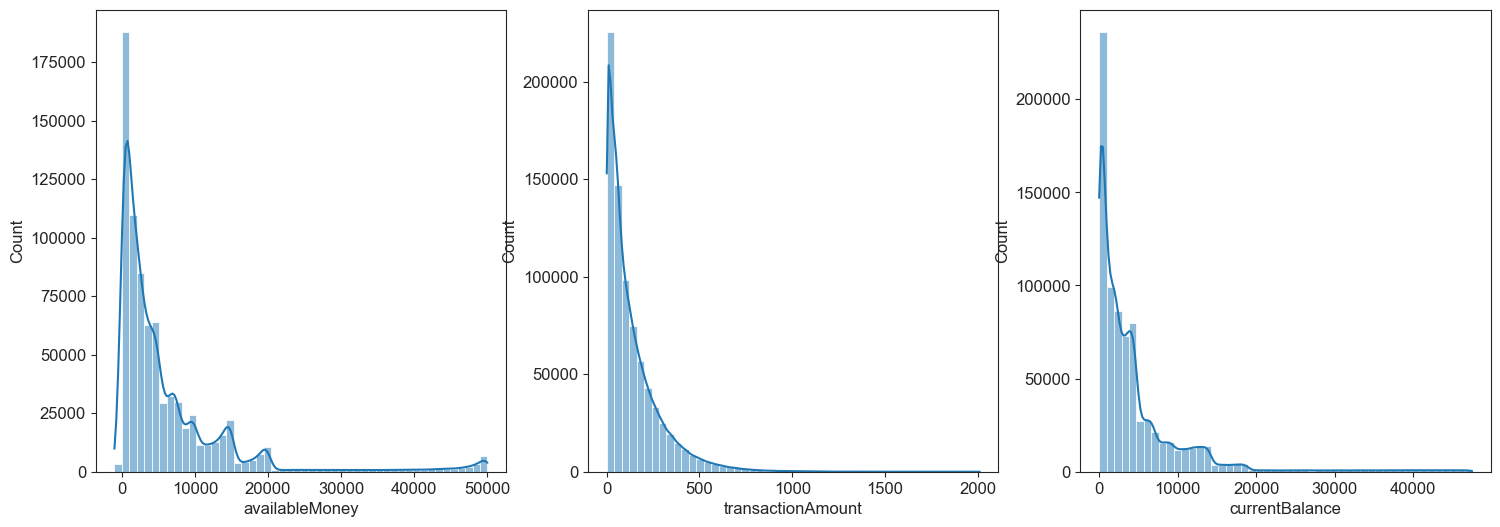

In [183]:
# histogram the numerical columns
fig, ax = plt.subplots(1,3, figsize=(18,6))
sns.histplot(x_num['availableMoney'], kde=True, ax=ax[0], bins=50)
sns.histplot(x_num['transactionAmount'], kde=True, ax=ax[1], bins=50)
sns.histplot(x_num['currentBalance'], kde=True, ax=ax[2], bins=50)
plt.show()

As aforementioned, the numerical columns display wide ranges and gigantic right-skewness. So, we will Box-Cox transform them to make them more Gaussian-like.

In [184]:
# Box-Cox transform ['availableMoney', 'transactionAmount', 'currentBalance'] columns in x_num with lambda=0.25. Notice that some of the 'availableMoney' are negative with a minimum of -1005.6, so we need to add a constant to make them all non-negative.
x_num_bc = x_num.copy()
x_num_bc['bc_availableMoney'] = sp.stats.boxcox(x_num['availableMoney'],lmbda=0.25)
x_num_bc['bc_transactionAmount'] = sp.stats.boxcox(x_num['transactionAmount'],lmbda=0.25)
x_num_bc['bc_currentBalance'] = sp.stats.boxcox(x_num['currentBalance']+1006,lmbda=0.25)
# drop the original columns
x_num_bc.drop(columns=['availableMoney','transactionAmount','currentBalance'], inplace=True)
# hstack x_xum_bc with y
x_num_bc = pd.concat([x_num_bc, y], axis=1)
# check the statistics of the Box-Cox transformed ['creditLimit','transactionAmount','availableMoney'] columns
x_num_bc.describe()

,bc_availableMoney,bc_transactionAmount,bc_currentBalance,isFraud
count,783432.000000,786363.000000,786363.000000,786363.000000
mean,26.692054,8.045755,27.774538,0.015790
std,10.489219,4.109909,7.390337,0.124664
min,-2.108517,-4.000000,18.527318,0.000000
25%,19.016807,5.633991,21.669103,0.000000
50%,26.103727,8.247775,26.673173,0.000000
75%,33.224194,10.879586,31.632398,0.000000
max,55.813951,22.788115,55.361681,1.000000


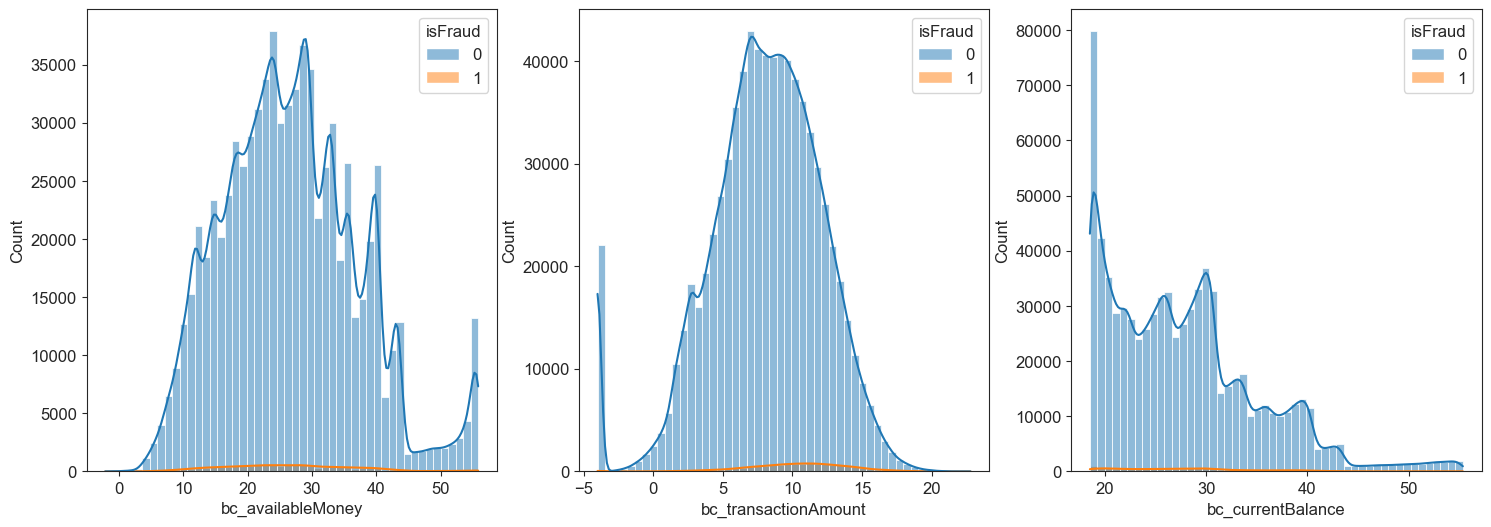

In [185]:
# use seaborn to check the histograms of the Box-Cox transformed ['availableMoney','transactionAmount','currentBalance'] columns of isFraud=0 or 1  group separately with the kde on 
fig, ax = plt.subplots(1,3, figsize=(18,6))
sns.histplot(x_num_bc, x='bc_availableMoney', hue='isFraud', kde=True, ax=ax[0], bins=50)
sns.histplot(x_num_bc, x='bc_transactionAmount', hue='isFraud', kde=True, ax=ax[1], bins=50)
sns.histplot(x_num_bc, x='bc_currentBalance', hue='isFraud', kde=True, ax=ax[2], bins=50)
plt.show()

In [186]:
# Box-Cox transform ['availableMoney', 'transactionAmount', 'currentBalance'] columns in df with lambda=0.25
df['bc_availableMoney'] = sp.stats.boxcox(df['availableMoney'],lmbda=0.25)
df['bc_transactionAmount'] = sp.stats.boxcox(df['transactionAmount'],lmbda=0.25)
df['bc_currentBalance'] = sp.stats.boxcox(df['currentBalance'],lmbda=0.25)


## 3.3 Categorical variables overview

The as-is dataset has 25 non-numerical variables, 4 datetime, 21 categorical/boolean. 

- There are empty strings in the dataset whom should be regarded as missing values, and we used the regular expression to convert the empty strings to np.nan. As a result, we found 6 columns, ['echoBuffer', 'merchantCity', 'merchantState', 'merchantZip', 'posOnPremises', 'recurringAuthInd'], are nothing but np.nans, mostly like they do it intentionally to anonymize some geographic and POS tags.
- The columns ['accountOpenDate', 'dateOfLastAddressChange', 'transactionDateTime'] are supposed to be datetimes. Cconvert them to datetime objects.
- Convert the boolean columns ['cardPresent', 'expirationDateKeyInMatch] to 0s and 1s.

In [188]:
# deselect numerical columns and concatenate the creditLimit column to x_cat
x_cat = x.select_dtypes(exclude='number')
x_cat['creditLimit'] = x['creditLimit'].astype(int).astype(str)
x_cat.head()

,accountNumber,customerId,transactionDateTime,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,currentExpDate,accountOpenDate,dateOfLastAddressChange,cardCVV,enteredCVV,cardLast4Digits,transactionType,echoBuffer,merchantCity,merchantState,merchantZip,cardPresent,posOnPremises,recurringAuthInd,expirationDateKeyInMatch,creditLimit
0,737265056,737265056,2016-08-13 14:27:32,Uber,US,US,02,01,rideshare,06/2023,2015-03-14,2015-03-14,414,414,1803,PURCHASE,,,,,False,,,False,5000
1,737265056,737265056,2016-10-11 05:05:54,AMC #191138,US,US,09,01,entertainment,02/2024,2015-03-14,2015-03-14,486,486,767,PURCHASE,,,,,True,,,False,5000
2,737265056,737265056,2016-11-08 09:18:39,Play Store,US,US,09,01,mobileapps,08/2025,2015-03-14,2015-03-14,486,486,767,PURCHASE,,,,,False,,,False,5000
3,737265056,737265056,2016-12-10 02:14:50,Play Store,US,US,09,01,mobileapps,08/2025,2015-03-14,2015-03-14,486,486,767,PURCHASE,,,,,False,,,False,5000
4,830329091,830329091,2016-03-24 21:04:46,Tim Hortons #947751,US,US,02,01,fastfood,10/2029,2015-08-06,2015-08-06,885,885,3143,PURCHASE,,,,,True,,,False,5000


In [189]:
# replace empty strings with np.nan while downcasting the changed columns' data types
pd.set_option('future.no_silent_downcasting', True)
x_cat = x_cat.replace(r'^\s*$', np.nan, regex=True)
df = df.replace(r'^\s*$', np.nan, regex=True)

In [190]:
# convert the datetime columns to datetime objects in df
df['accountOpenDate'] = pd.to_datetime(df['accountOpenDate'])
df['dateOfLastAddressChange'] = pd.to_datetime(df['dateOfLastAddressChange'])
df['transactionDateTime'] = pd.to_datetime(df['transactionDateTime'])

In [191]:
# Convert the boolean columns ['cardPresent', 'expirationDateKeyInMatch] to integers of binary in x_cat and df
df['cardPresent'] = df['cardPresent'].astype(int)
df['expirationDateKeyInMatch'] = df['expirationDateKeyInMatch'].astype(int)

## 3.4 Outliers 
- As aforementioned, the numerical columns display wide ranges and gigantic skewness. So, it's imperative to perform some sort of transformations to make them more Gaussian-like. We pick the Box-Cox transformation, then use eye-balling and a wider than normally used Tukey's fences method to detect the outliers.
- It's obvious that our 3 numerical columns are highly correlated by definition. Thus, we only need to detect and handle the outliers for the Box-Cox transformed ['creditLimit','transactionAmount','availableMoney'] columns.
- Since we plan to work with Box-Cox transformed columns in the modeling phase, so we will be conservative in the outlier detection and cap them by the Tukey's fences method with 2 times of IQR instead of 1.5 time.
- As a result, 11 outliers are detected with transaction amount higher than 1680.00, and they are all non-fraudulent transactions.


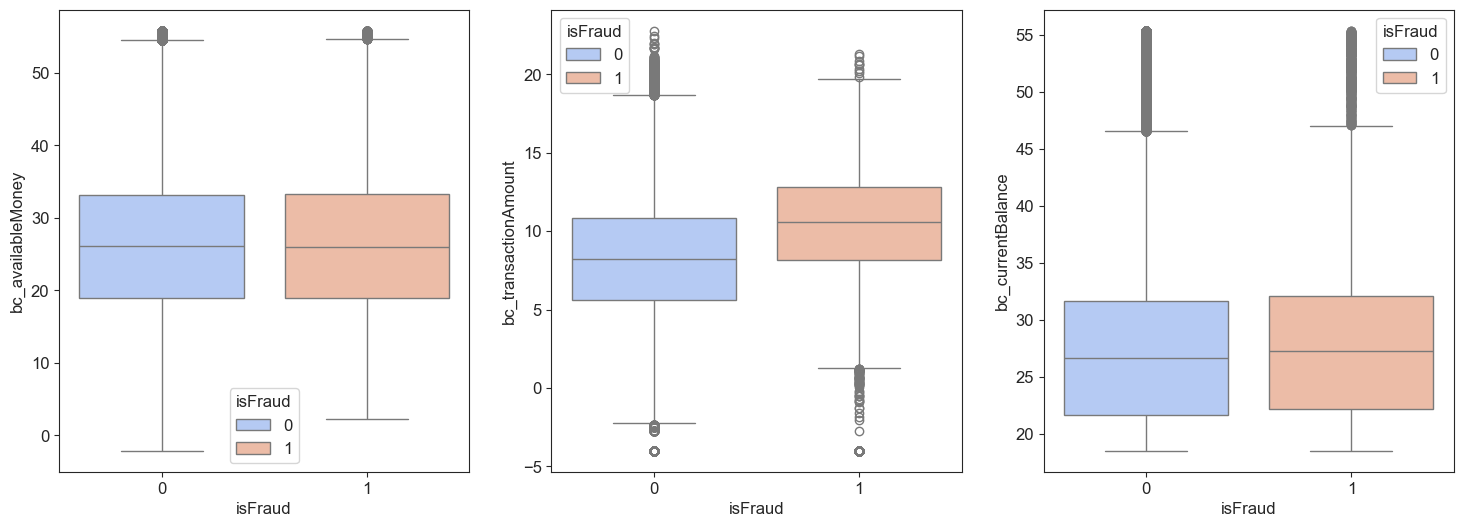

In [192]:
# use sns to plot the boxplot of the Box-Cox transformed ['availableMoney','transactionAmount','currentBalance'] columns isFraud=0or1 group with different color
fig, ax = plt.subplots(1,3, figsize=(18,6))
sns.boxplot(x='isFraud', y='bc_availableMoney', data=x_num_bc, ax=ax[0], hue='isFraud', palette='coolwarm')
sns.boxplot(x='isFraud', y='bc_transactionAmount', data=x_num_bc, ax=ax[1], hue='isFraud',palette='coolwarm')
sns.boxplot(x='isFraud', y='bc_currentBalance', data=x_num_bc, ax=ax[2], hue='isFraud',palette='coolwarm')
plt.show()

In [193]:
# use the Tukey's fense method to detect the outliers in the Box-Cox transformed ['creditLimit','transactionAmount','availableMoney'] columns
k = 2
def tukey_fences(x, k):
    q1 = x.quantile(0.25)
    q3 = x.quantile(0.75)
    iqr = q3 - q1
    return (x < (q1 - k * iqr)) | (x > (q3 + k * iqr))
a = tukey_fences(x_num_bc['bc_availableMoney'],k=k).sum()
b = tukey_fences(x_num_bc['bc_transactionAmount'],k=k).sum()
c = tukey_fences(x_num_bc['bc_currentBalance'],k=k).sum()
print(f'bc_creditLimit has {a} outliers when we set the k = {k}.')
print(f'bc_transactionAmount has {b} outliers when we set the k = {k}.')
print(f'bc_availableMoney has {c} outliers when we set the k = {k}.')

bc_creditLimit has 0 outliers when we set the k = 2.
bc_transactionAmount has 11 outliers when we set the k = 2.
bc_availableMoney has 9163 outliers when we set the k = 2.


In [195]:
# Since the outliers come from large transactions, let us find the top 11 transactions with the largest transactionAmount
outlier_index = x_num.nlargest(11, 'transactionAmount').index
x_num.loc[outlier_index].sort_values(['transactionAmount'], ascending=False)

,availableMoney,transactionAmount,currentBalance
380125,47991.66,2011.54,2008.34
498620,18259.98,1905.30,1740.02
673073,10484.42,1873.97,4515.58
778423,9006.27,1780.60,993.73
424567,1129.87,1772.63,1370.13
612391,4225.92,1767.50,10774.08
679917,346.02,1710.13,4653.98
371878,142.21,1707.80,357.79
308817,480.98,1704.55,19.02
501537,15000.00,1693.36,0.00


In [196]:
# Since they are all non-fraud, nothing really seem to suspicious, and 11 is trivial compared to the sheer size of 783K rows, we just delete the 11 outliers for now
df.drop(index=outlier_index, inplace=True)
df.reset_index(drop=True, inplace=True)

## 3.5 Missing values 

- The label column has no missing values.
- The numerical columns have no missing values.
- The categorical columns have missing values. Given the hidden structure between the categorical features, we'd like to be extra conservative and do missing value imputations univariately and accordingly instead of a universal multivariate approach such as k-NN imputer or iterative imputer.
 1. 3.5.1 Drop the six all NaN columns ['echoBuffer', 'merchantCity', 'merchantState', 'merchantZip', 'posOnPremises', 'recurringAuthInd']
 2. 3.5.2 The column ['acqCountry'] has 4562 missing values. The missing seems to be most likely missing not at random(MNAR). The missing values will be imputed by the mode of the rows with the same ['accountNumber','cardLast4Digits'] columns' combination primarily or by ['accountNumber'] column itself secondarily.
 3. 3.5.3 The column ['merchantCountryCode'] has 724 missing values. The missing seems to be most likely missing not at random(MNAR). The missing values will be imputed by the mode of the rows with ['merchantName'] column primarily .
 4. 3.5.4 The column ['transactionType'] has 698 missing values. Due to lack of relative information, we simply label the missing values as 'Unknown' for now. 
 5. 3.5.5 The column ['posConditionCode'] has 409 missing values. Due to the contradicting code from transactions made at the same merchant, we simply label the missing values as 'Unknown' for now.
 6. 3.5.6 The column ['posEntryMode'] has 4054 missing values. Due to the same reason as column ['posConditionCode'], we simply label the missing values as 'Unknown' for now.  

In [197]:
# screen for missing values in the categorical columns
x_cat.isna().sum().sort_values(ascending=False)

recurringAuthInd            786363
posOnPremises               786363
merchantZip                 786363
merchantState               786363
merchantCity                786363
echoBuffer                  786363
acqCountry                    4562
posEntryMode                  4054
merchantCountryCode            724
transactionType                698
posConditionCode               409
accountNumber                    0
expirationDateKeyInMatch         0
cardPresent                      0
cardCVV                          0
cardLast4Digits                  0
enteredCVV                       0
customerId                       0
dateOfLastAddressChange          0
accountOpenDate                  0
currentExpDate                   0
merchantCategoryCode             0
merchantName                     0
transactionDateTime              0
creditLimit                      0
dtype: int64

### 3.5.1 Drop the six all NaN columns ['echoBuffer', 'merchantCity', 'merchantState', 'merchantZip', 'posOnPremises', 'recurringAuthInd'] 

There are empty strings in the dataset whom should be regarded as missing values, and we used the regular expression to convert the empty strings to np.nan. As a result, we found 6 columns, ['echoBuffer', 'merchantCity', 'merchantState', 'merchantZip', 'posOnPremises', 'recurringAuthInd'], are nothing but np.nans, mostly like they do it intentionally to anonymize some geographic and POS tags. Then drop them all.

In [198]:
# drop the six all NaN columns
x_cat.drop(columns=['echoBuffer', 'merchantCity', 'merchantState', 'merchantZip', 'posOnPremises', 'recurringAuthInd'], inplace=True)
df.drop(columns=['echoBuffer', 'merchantCity', 'merchantState', 'merchantZip', 'posOnPremises', 'recurringAuthInd'], inplace=True)

In [199]:
# check the missing values in the rest columns
x_cat.isna().sum().sort_values(ascending=False)

acqCountry                  4562
posEntryMode                4054
merchantCountryCode          724
transactionType              698
posConditionCode             409
accountNumber                  0
cardCVV                        0
expirationDateKeyInMatch       0
cardPresent                    0
cardLast4Digits                0
enteredCVV                     0
currentExpDate                 0
dateOfLastAddressChange        0
accountOpenDate                0
customerId                     0
merchantCategoryCode           0
merchantName                   0
transactionDateTime            0
creditLimit                    0
dtype: int64

### 3.5.2 The column ['acqCountry'] has 4,562 missing values.
- Among the missing values in the 'acqCountry' column, 3.3% are fraudulent. They are most likely missing completely at random(MCAR), albeit sufficient checks on the group characteristics between the missing and non-missing.
- The 4,562 transactions with missing values come from 1,495 accounts. 
- We will impute them by the mode of the rows with the same ['accountNumber'] primarily.
- For 1,494 accounts that can have a mode value. Due to the fact the dataset is predominantly from the US customers, their modes are all US actually. 
- The remaining 1 account,'997884003', who has no record of 'acqCountry' only have 3 non-default transactions from apple's appstore, we will assume it with 'US' as well for now. They can also be dropped later on if they are not informative.

In [200]:
# check the missing values in the 'acqCountry' column's distribution by the label column
y[x_cat['acqCountry'].isna()].value_counts()/ y[x_cat['acqCountry'].isna()].shape[0]

isFraud
0    0.967339
1    0.032661
Name: count, dtype: float64

In [201]:
# check the unique values of the 'acqCountry' of all transactions. We can see the 'US' is predominantly dominating in this filed, more than 98.5%. 
x_cat['acqCountry'].value_counts(dropna=False)/x_cat.shape[0]

acqCountry
US     0.985180
NaN    0.005801
MEX    0.003980
CAN    0.003083
PR     0.001956
Name: count, dtype: float64

In [202]:
# check the unique values of the 'accountNumber' of the transactions having missing values in the 'acqCountry' column
a = x_cat[x_cat['acqCountry'].isna()][['accountNumber']].drop_duplicates()
# check the mode of the 'acqCountry' column by the ['accountNumber'] column's group
b = x_cat[x_cat['accountNumber'].isin(a['accountNumber'])][['accountNumber','acqCountry']].groupby(['accountNumber']).agg(pd.Series.mode).astype(str)
b['acqCountry'].value_counts().reset_index()

,acqCountry,count
0,US,1494
1,[],1


In [203]:
b[b['acqCountry'] != 'US']

,acqCountry
accountNumber,
997884003,[]


In [204]:
# check the transactions of the accountNumber '997884003', we can see there is no info on its acqCountry, but the owner shops on the US iTunes store, also given the fact the dataset is predominantly from the US customers, we will assume it with 'US' as well for now.
df[df['accountNumber']=='997884003']

,accountNumber,customerId,creditLimit,transactionDateTime,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,currentExpDate,accountOpenDate,dateOfLastAddressChange,cardCVV,enteredCVV,cardLast4Digits,transactionType,cardPresent,expirationDateKeyInMatch,isFraud,bc_availableMoney,bc_transactionAmount,bc_currentBalance
107475,997884003,997884003,7500.0,2016-10-27 20:48:49,Apple iTunes,NaN,US,09,08,mobileapps,12/2028,2014-11-20,2014-11-20,101,101,9397,PURCHASE,0,0,False,33.224194,2.924351,-4.0
107476,997884003,997884003,7500.0,2016-11-27 04:49:57,Apple iTunes,NaN,US,09,08,mobileapps,12/2028,2014-11-20,2014-11-20,101,101,9397,PURCHASE,0,0,False,33.224194,2.924351,-4.0
107477,997884003,997884003,7500.0,2016-12-28 23:09:24,Apple iTunes,NaN,US,09,08,mobileapps,12/2028,2014-11-20,2014-11-20,101,101,9397,PURCHASE,0,0,False,33.224194,2.924351,-4.0


In [205]:
# fill the NaNs in 'acqCountry' as US for its missing for all accounts for now
df.loc[df['acqCountry'].isna(),'acqCountry'] = 'US'

### 3.5.3 The column ['merchantCountryCode'] has 724 missing values.
- Among the missing values in the 'acqCountry' column, 1.1% are fraudulent. They are most likely missing completely at random(MCAR), albeit sufficient checks on the group characteristics between the missing and non-missing.
- The 724 transactions with missing values come from 293 merchants. 
- We will impute them by the mode of the rows with the same ['merchantName'] primarily.
- Due to the fact the dataset is predominantly from the US merchants, their modes are all US. 

In [206]:
# check the missing values in the ['merchantCountryCode'] column's distribution by the label column
y[x_cat['merchantCountryCode'].isna()].value_counts()/ y[x_cat['merchantCountryCode'].isna()].shape[0]

isFraud
0    0.88674
1    0.11326
Name: count, dtype: float64

In [207]:
# check the unique values of the 'merchantCountryCode' of all transactions. We can see the 'US' is predominantly dominating in this filed, more than 99%.
x_cat['merchantCountryCode'].value_counts(dropna=False)/x_cat.shape[0]

merchantCountryCode
US     0.990015
MEX    0.003997
CAN    0.003085
PR     0.001983
NaN    0.000921
Name: count, dtype: float64

In [208]:
# check the unique values of the ['merchantName','merchantCategoryCode'] of the transactions having missing values in the 'merchantCountryCode' column
a = x_cat[x_cat['merchantCountryCode'].isna()][['merchantCountryCode','merchantName','merchantCategoryCode']].drop_duplicates()
# check the mode of the 'merchantCountryCode' column by the 'merchantName' column's group
b = x_cat[x_cat['merchantName'].isin(a['merchantName'])][['merchantName','merchantCountryCode']].groupby(['merchantName']).agg(pd.Series.mode).astype(str)
b['merchantCountryCode'].value_counts().reset_index()

,merchantCountryCode,count
0,US,293


In [209]:
# impute 'merchantCountryCode' as US for its missing for all merchants
df.loc[df['merchantCountryCode'].isna(),'merchantCountryCode'] = 'US'

### 3.5.4 The column ['transactionType'] has 698 missing values.
- Among the missing values in the 'acqCountry' column, 2.0% are fraudulent. They are most likely missing completely at random(MCAR), albeit sufficient checks on the group characteristics between the missing and non-missing.
- Due to lack of relative information, we simply label the missing values as 'Unknown' for now. 

In [210]:
# check the missing values in the ['transactionType'] column's distribution by the label column
y[x_cat['transactionType'].isna()].value_counts()/ y[x_cat['transactionType'].isna()].shape[0]

isFraud
0    0.979943
1    0.020057
Name: count, dtype: float64

In [211]:
# check the unique values of the 'transactionType' of all transactions. We can see the 'PURCHASE' is dominating in this filed with about 94.8%. So, imputing with the mode is a no longer as solid as before, especially when the missing values are not negligible and other features cannot provide a clue.
x_cat['transactionType'].value_counts(dropna=False)/x_cat.shape[0]

transactionType
PURCHASE                0.947645
REVERSAL                0.025819
ADDRESS_VERIFICATION    0.025648
NaN                     0.000888
Name: count, dtype: float64

In [212]:
# impute 'transactionType' as 'Unknown' for its missing for all transactions
df.loc[df['transactionType'].isna(),'transactionType'] = 'Unknown'

### 3.5.5 The column ['posConditionCode'] has 409 missing values.
- Among the missing values in the 'acqCountry' column, 5.4% are fraudulent. They are most likely missing completely at random(MCAR), albeit sufficient checks on the group characteristics between the missing and non-missing.
- Due to the contradicting code from transactions made at the same merchant, we simply label the missing values as 'Unknown' for now. 

In [213]:
# check the missing values in the ['merchantCountryCode'] column's distribution by the label column
y[x_cat['posConditionCode'].isna()].value_counts()/ y[x_cat['posConditionCode'].isna()].shape[0]

isFraud
0    0.94621
1    0.05379
Name: count, dtype: float64

In [214]:
# check the unique values of the 'posConditionCode' of all transactions. We can see the '01' is dominating in this filed with about 80%. So, imputing with the mode is a no longer as solid as before.
x_cat['posConditionCode'].value_counts(dropna=False)/x_cat.shape[0]

posConditionCode
01     0.799614
08     0.190286
99     0.009580
NaN    0.000520
Name: count, dtype: float64

In [215]:
# check the unique values of the 'merchantName' of the transactions having missing values in the 'posConditionCode' column. Not all transactions from the same merchant have the same 'posConditionCode'.
x_cat.loc[x_cat['posConditionCode'].isna(),['merchantName']].value_counts(dropna=False) 

merchantName        
Shell Gas #256420       25
Lyft                    19
walmart.com             15
Uber                    13
cheapfast.com           12
                        ..
Franks Pub #960098       1
Franks Sandwitch Bar     1
Golds Gym #195674        1
Hardee's #758387         1
williamssonoma.com       1
Name: count, Length: 190, dtype: int64

In [216]:
# check the unique values of the 'posConditionCode' of the transactions having the same 'merchantName' of the transactions having missing values in the 'posConditionCode' column. Not all transactions from the same merchant have the same 'posConditionCode'.
x_cat.loc[(x_cat['merchantName'] == 'Shell Gas #256420') ,'posConditionCode'].value_counts(dropna=False)

posConditionCode
01     185
NaN     25
08      14
Name: count, dtype: int64

In [217]:
# check the unique values of the 'posConditionCode' of the transactions having the same 'merchantName' of the transactions having missing values in the 'posConditionCode' column. Not all transactions from the same merchant have the same 'posConditionCode'.
x_cat.loc[x_cat['merchantName'] == 'Lyft','posConditionCode'].value_counts(dropna=False)

posConditionCode
01     20284
08      4974
99       246
NaN       19
Name: count, dtype: int64

In [218]:
# check the unique values of the 'posConditionCode' of the transactions having the same 'merchantName' of the transactions having missing values in the 'posConditionCode' column. Not all transactions from the same merchant have the same 'posConditionCode'.
x_cat.loc[x_cat['merchantName'] == 'walmart.com','posConditionCode'].value_counts(dropna=False)

posConditionCode
01     13447
08      3246
99       165
NaN       15
Name: count, dtype: int64

In [219]:
# impute 'posConditionCode' as 'Unknown' for its missing for all transactions
df.loc[df['posConditionCode'].isna(),'posConditionCode'] = 'Unknown'

### 3.5.6 The column ['posEntryMode'] has 4,054 missing values.
- Among the missing values in the 'acqCountry' column, 6.6% are fraudulent. They are most likely missing completely at random(MCAR), albeit sufficient checks on the group characteristics between the missing and non-missing.
- Due to the same reason as column ['posConditionCode'], we simply label the missing values as 'Unknown' for now. 

In [220]:
# check the missing values in the ['posEntryMode'] column's distribution by the label column
y[x_cat['posEntryMode'].isna()].value_counts()/ y[x_cat['posEntryMode'].isna()].shape[0]

isFraud
0    0.933646
1    0.066354
Name: count, dtype: float64

In [221]:
# check the unique values of the 'posEntryMode' of all transactions. We can see no code is the majority. So, imputing with the mode is not acceptable, we will label the missing values as 'Unknown' for now.
x_cat['posEntryMode'].value_counts(dropna=False)/x_cat.shape[0]

posEntryMode
05     0.400623
09     0.300728
02     0.249165
90     0.024894
80     0.019435
NaN    0.005155
Name: count, dtype: float64

In [222]:
# impute 'posEntryMode' as 'Unknown' for its missing for all transactions
df.loc[df['posEntryMode'].isna(),'posEntryMode'] = 'Unknown'

In [223]:
# verify all missing values have been imputed
df.isna().sum().sort_values(ascending=False)

bc_availableMoney           2931
accountNumber                  0
dateOfLastAddressChange        0
bc_transactionAmount           0
isFraud                        0
expirationDateKeyInMatch       0
cardPresent                    0
transactionType                0
cardLast4Digits                0
enteredCVV                     0
cardCVV                        0
accountOpenDate                0
customerId                     0
currentExpDate                 0
merchantCategoryCode           0
posConditionCode               0
posEntryMode                   0
merchantCountryCode            0
acqCountry                     0
merchantName                   0
transactionDateTime            0
creditLimit                    0
bc_currentBalance              0
dtype: int64

## 3.6 Feature Engineering

The as-is dataset has 3 numerical features and 25 non-numerical features, 4 datetime, 21 categorical/boolean. The post-preprocessed dataset will have 3 numerical features and 21 categorical features, 8 datetime, 13 categorical/boolean, after we discard the non-informative columns and re-construct the verbose ones.

1. Note the ['accountNumber'] and ['customerId'] columns are identical. We will drop the customerId column.
2. The column ['currentExpDate'] is a string column in format mm/yy. We will convert it to a datetime object by impute them to the last day of the month. We first convert to the 1st day of the month, then add 1 month and subtract 1 day, finally convert it to datetime objects.
3. Extract the 'x_hour', 'x_day_of_week', 'x_day_of_month', 'x_month', 'x_year', 'day_since_open', 'day_since_update_add', and 'day_2_exp' from the existing columns and drop the original ones.
4. Coalesce the information contained in ['cardCVV', 'enteredCVV'] columns to a new categorical ['mismatchInCVV'] column showing the number of mismatches by comparing the 3 integers in each row of the two aforementioned columns. And we restrain from diving into the analysis of which of the integers cause mismatches for now.
5. Truncate the ['merchantName'] starting from the first #, reducing the number of merchants from 2489 to 205. __Maybe we can further reduce the number of merchants by grouping the tail 20%__.

In [224]:
# 1. drop the customerId column for duplication from df
df.customerId.equals(df.accountNumber)
df.drop(columns='customerId', inplace=True)

In [225]:
# 2. impute the format mm/yy to the last day of the month of the column currentExpDate by first convert to the 1st day of the month, then add 1 month and subtract 1 day, finally convert it to datetime objects.
df['currentExpDate'] = pd.to_datetime(df['currentExpDate'].apply(lambda x: '01/' + x),dayfirst=True) + pd.DateOffset(months=1) - pd.DateOffset(days=1)

In [226]:
# 3. extract the 'x_hr', 'x_d', 'x_DOW', 'x_mon', 'x_yr', 't_since_open', 't_since_update_add', and 't_2_exp' from the existing columns and drop the original ones
df['x_hr'] = df['transactionDateTime'].dt.hour
df['x_d'] = df['transactionDateTime'].dt.day
df['x_DOW'] = df['transactionDateTime'].dt.dayofweek
df['x_mon'] = df['transactionDateTime'].dt.month
df['x_yr'] = df['transactionDateTime'].dt.year
df['t_since_open'] = (df['transactionDateTime'] - df['accountOpenDate']).dt.days
df['t_since_update_add'] = (df['transactionDateTime'] - df['dateOfLastAddressChange']).dt.days
df['t_2_exp'] = (df['currentExpDate'] - df['transactionDateTime']).dt.days
# drop the original columns
df.drop(columns=['accountOpenDate', 'dateOfLastAddressChange', 'transactionDateTime', 'currentExpDate'], inplace=True)

In [227]:
# 4. convert the 3 integers in each row of 'cardCVV' and 'enteredCVV' columns to  new ndarrays with 3 columns of integers
a = np.stack(df['cardCVV'].map(lambda x: list(map(int, x))).to_list())
b = np.stack(df['enteredCVV'].map(lambda x: list(map(int, x))).to_list())
# create a new column 'mismatchInCVV' showing the number of mismatches by comparing the 3 integers in each row of the two aforementioned columns
df['mismatchInCVV'] = pd.Series(np.sum(a != b, axis=1)).astype(np.short)
# drop the 'cardCVV' and 'enteredCVV' columns
df.drop(columns=['cardCVV', 'enteredCVV'], inplace=True)

In [228]:
# 7. Convert the boolean columns ['cardPresent', 'expirationDateKeyInMatch] to 4-ply for the convenience of modeling.
df['cardPresent'] = df['cardPresent'].astype(int)
df['expirationDateKeyInMatch'] = df['expirationDateKeyInMatch'].astype(int)

In [229]:
# 5. Truncate the ['merchantName'] starting from the first #, reducing the number of merchants from 2489 to 205.
df['merchantName'] = df['merchantName'].str.split('#').str[0]
df['merchantName'].nunique()

205

In [230]:
df.columns

Index(['accountNumber', 'creditLimit', 'merchantName', 'acqCountry',
       'merchantCountryCode', 'posEntryMode', 'posConditionCode',
       'merchantCategoryCode', 'cardLast4Digits', 'transactionType',
       'cardPresent', 'expirationDateKeyInMatch', 'isFraud',
       'bc_availableMoney', 'bc_transactionAmount', 'bc_currentBalance',
       'x_hr', 'x_d', 'x_DOW', 'x_mon', 'x_yr', 't_since_open',
       't_since_update_add', 't_2_exp', 'mismatchInCVV'],
      dtype='object')

In [231]:
# save the preprocessed data to a new .csv files
df.to_csv('transactions/transactions_preprocessed.csv', index=False)

# 4. Exploratory Data Analysis

In [ ]:
# read the preprocessed data from the .csv file
df = pd.read_csv('transactions/transactions_preprocessed.csv')

In [232]:
# split the df into y, x_num and x_cat, and get the x_num_bc via Box-Cox transformation with lambda=0.25
y = df['isFraud']
x_num = df[['availableMoney', 'transactionAmount', 'currentBalance']]
x_num_bc = x_num.copy()
x_num_bc['bc_currentBalance'] = sp.stats.boxcox(x_num['currentBalance'],lmbda=0.25)
x_num_bc['bc_transactionAmount'] = sp.stats.boxcox(x_num['transactionAmount'],lmbda=0.25)
x_num_bc['bc_availableMoney'] = sp.stats.boxcox(x_num['availableMoney']+1006,lmbda=0.25)
# drop the original columns
x_num_bc.drop(columns=['availableMoney', 'transactionAmount', 'currentBalance'], inplace=True)
# hstack x_xum_bc with y
x_num_bc = pd.concat([x_num_bc, y], axis=1)
x_cat = df.drop(columns=['availableMoney', 'transactionAmount', 'currentBalance', 'isFraud'])
x_num.describe()

KeyError: "None of [Index(['availableMoney', 'transactionAmount', 'currentBalance'], dtype='object')] are in the [columns]"

In [233]:
x_cat = df[['accountNumber',
    'cardLast4Digits',
    'creditLimit',
    'acqCountry',
 'transactionType',
 'merchantName',
 'merchantCountryCode',
 'merchantCategoryCode',
 'posEntryMode',
 'posConditionCode',
 'cardPresent',
 'expirationDateKeyInMatch',
 'mismatchInCVV',
 'x_hr',
 'x_d',
 'x_DOW',
 'x_mon',
 'x_yr',
 't_since_open',
 't_since_update_add',
 't_2_exp']]
x_cat.head()

,accountNumber,cardLast4Digits,creditLimit,acqCountry,transactionType,merchantName,merchantCountryCode,merchantCategoryCode,posEntryMode,posConditionCode,cardPresent,expirationDateKeyInMatch,mismatchInCVV,x_hr,x_d,x_DOW,x_mon,x_yr,t_since_open,t_since_update_add,t_2_exp
0,737265056,1803,5000.0,US,PURCHASE,Uber,US,rideshare,02,01,0,0,0,14,13,5,8,2016,518,518,2511
1,737265056,767,5000.0,US,PURCHASE,AMC,US,entertainment,09,01,1,0,0,5,11,1,10,2016,577,577,2696
2,737265056,767,5000.0,US,PURCHASE,Play Store,US,mobileapps,09,01,0,0,0,9,8,1,11,2016,605,605,3217
3,737265056,767,5000.0,US,PURCHASE,Play Store,US,mobileapps,09,01,0,0,0,2,10,5,12,2016,637,637,3185
4,830329091,3143,5000.0,US,PURCHASE,Tim Hortons,US,fastfood,02,01,1,0,0,21,24,3,3,2016,231,231,4968


## 4.1 Numerical Features

In [252]:
## 4.1 Numerical Features
x_num_log = x_num.copy()
x_num_log.loc[x_num_log['transactionAmount'] <1, 'transactionAmount'] = np.nan
x_num_log.loc[x_num_log['creditLimit'] <1, 'creditLimit'] = np.nan
x_num_log.loc[x_num_log['availableMoney'] <1, 'availableMoney'] = np.nan
# hstack x_xum_bc with y
x_num_log = pd.concat([x_num_log, y], axis=1)

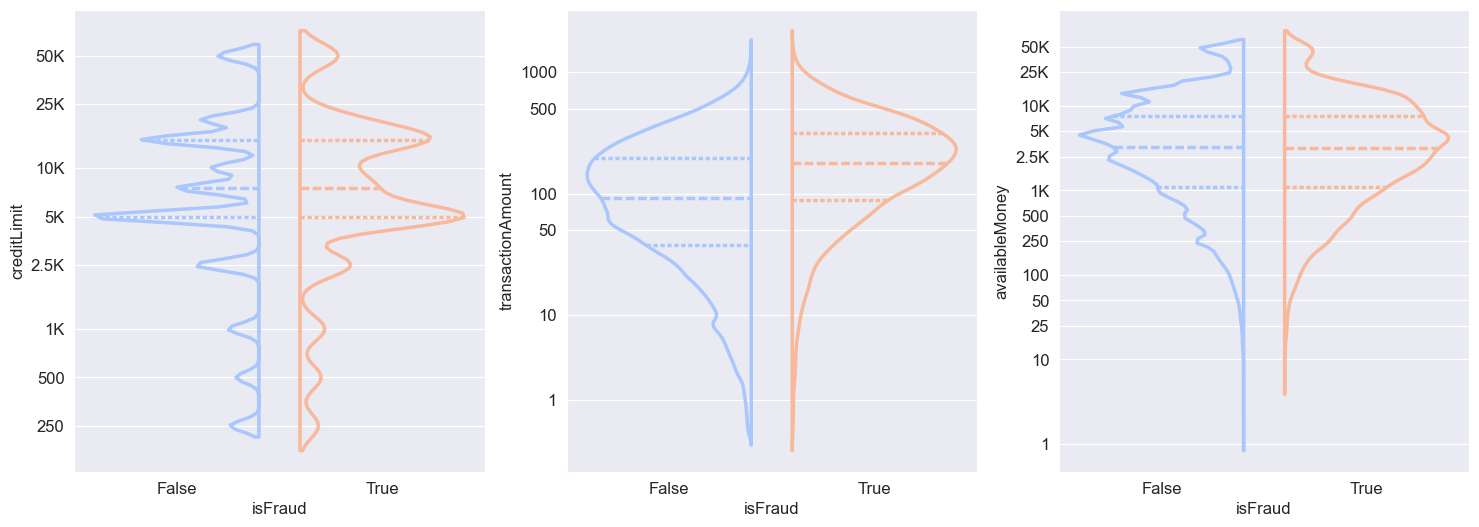

In [253]:
# Violin plot of the log-transformed numerical features by the label column, change the y label to log(creditLimit), log(transactionAmount), and log(availableMoney)
fig, ax = plt.subplots(1,3, figsize=(18,6))
sns.violinplot(x='isFraud', y='creditLimit', data=x_num_log, ax=ax[0], hue='isFraud', palette='coolwarm', split=True, inner='quartile', legend=False, fill=False, linewidth=2.5, log_scale=True)
ax[0].set_ylabel('creditLimit')
ax[0].set_yticks([250, 500, 10**3, 2500, 5000, 10**4, 25000, 50000])
ax[0].set_yticklabels(['250', '500', '1K', '2.5K', '5K',  '10K', '25K', '50K'])
sns.violinplot(x='isFraud', y='transactionAmount', data=x_num_log, ax=ax[1], hue='isFraud', palette='coolwarm', split=True, inner='quartile', legend=False, fill=False, linewidth=2.5, log_scale=True)
ax[1].set_ylabel('transactionAmount')
ax[1].set_yticks([2, 10, 50, 100, 500, 1000])
ax[1].set_yticklabels([ '1', '10', '50', '100', '500', '1000'])
sns.violinplot(x='isFraud', y='availableMoney', data=x_num_log, ax=ax[2], hue='isFraud', palette='coolwarm', split=True, inner='quartile', legend=False, fill=False, linewidth=2.5, log_scale=True)
ax[2].set_ylabel('availableMoney')
ax[2].set_yticks([1, 10,25,50,100,250, 500, 10**3, 2500, 5000, 10**4, 25000, 50000])
ax[2].set_yticklabels(['1','10','25','50','100','250', '500', '1K', '2.5K', '5K',  '10K', '25K', '50K'])
plt.show()

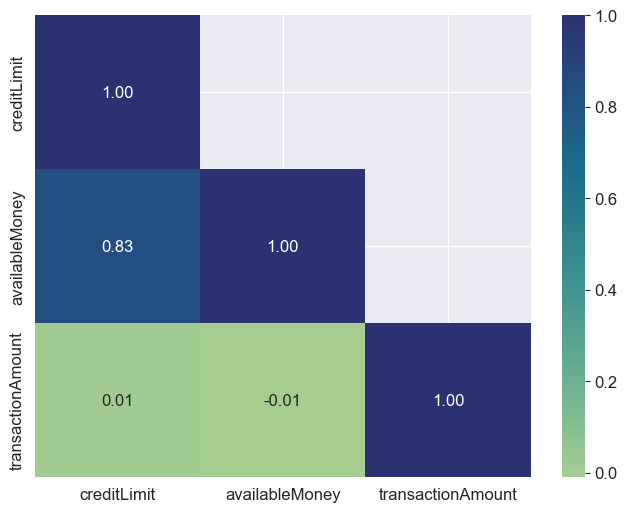

In [254]:
# Correlation lower triangle heatmap of the Box-Cox transformed numerical features
plt.figure(figsize=(8,6))
sns.heatmap(x_num.corr(), annot=True, cmap='crest', fmt=".2f", mask=np.triu(x_num.corr(), k=1))
plt.show()

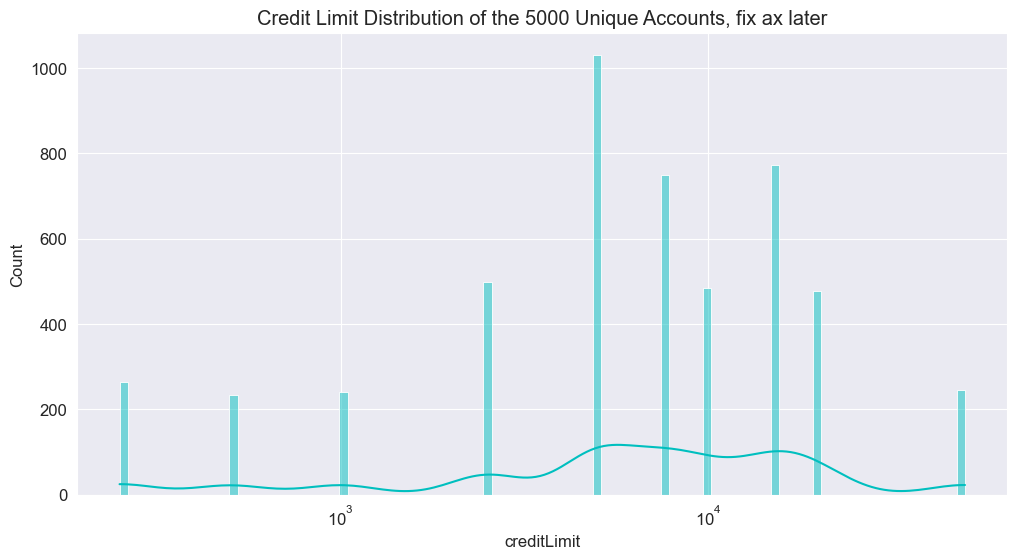

In [255]:
# Among the 5000 unique accounts, show their creditLimit distribution
a = df[['creditLimit', 'accountNumber']].groupby('accountNumber').agg(pd.Series.mode)
sns.histplot(a, x='creditLimit', bins=100, kde=True, color='c', log_scale=True)
plt.title('Credit Limit Distribution of the 5000 Unique Accounts, fix ax later')
plt.show()

## 4.2 Categorical Features
We might consider all non-US countries as one category, and all non-US merchants as one category, or delete all non-US accounts. 

### 4.2.1 Account oriented features analysis

In [257]:
# the top 10 accountNumber with the most fraudulent transactions
a = df[df['isFraud']==1]['accountNumber'].value_counts().sort_values(ascending=False)
a.head(10)

accountNumber
380680241    783
782081187    307
246251253    278
700725639    272
472288969    266
208319653    211
419709514    207
369308035    136
794398270    135
132629755    116
Name: count, dtype: int64

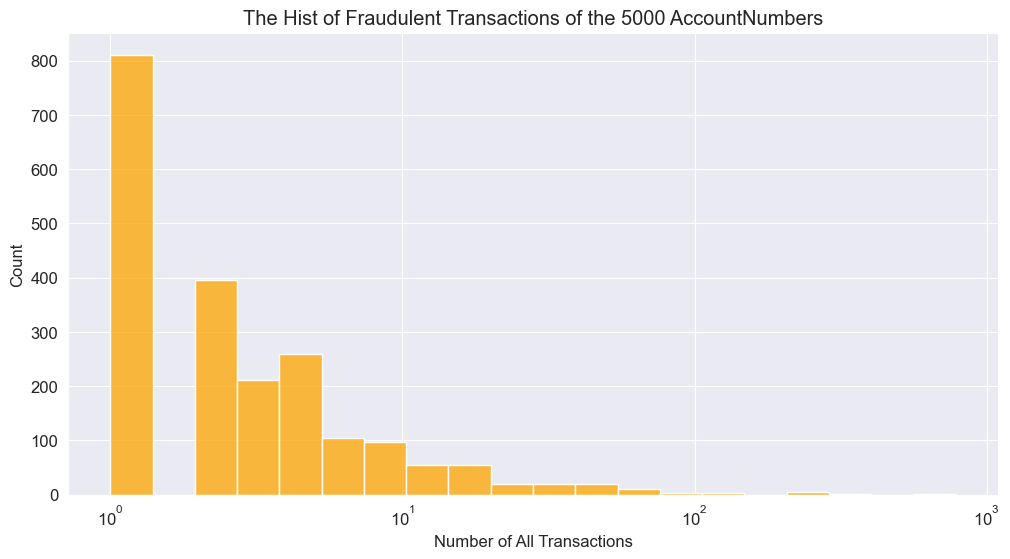

In [258]:
# histogram the a in the above cell
sns.histplot(a, bins=20, color='orange', log_scale=True)
plt.title('The Hist of Fraudulent Transactions of the 5000 AccountNumbers')
plt.xlabel('Number of All Transactions')
plt.show()

In [259]:
# the top 10 accountNumber with the most transactions
b = df['accountNumber'].value_counts().sort_values(ascending=False)
b.head(10)

accountNumber
380680241    32850
882815134    13189
570884863    10867
246251253    10172
369308035     7229
724518977     6283
894938833     6101
419709514     5930
832842201     5850
208319653     5235
Name: count, dtype: int64

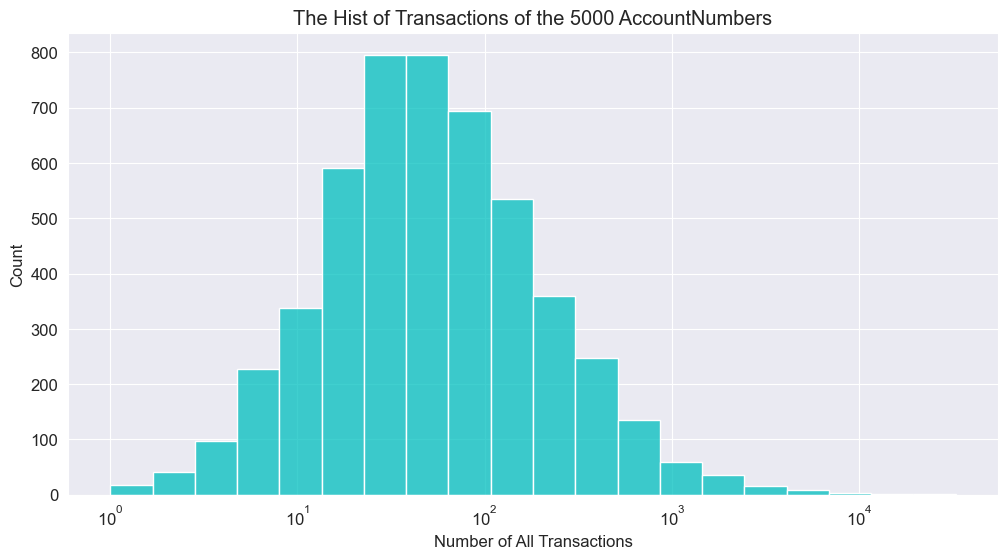

In [260]:
# histogram the a in the above cell
sns.histplot(b, bins=20, color='c', log_scale=True)
plt.title('The Hist of Transactions of the 5000 AccountNumbers')
plt.xlabel('Number of All Transactions')
plt.show()

In [261]:
# the percentage of the fraudulent transactions in the total transactions for each accountNumber
a = df.groupby('accountNumber')['isFraud'].agg(['count','sum'])
a['percentage'] = a['sum']/a['count']
a['percentage'].sort_values(ascending=False).head(10)

accountNumber
749645399    1.000000
356886744    1.000000
494400203    0.500000
666461201    0.500000
275266909    0.333333
938195288    0.307018
319012201    0.285714
336236533    0.277778
838703913    0.273585
672316951    0.248276
Name: percentage, dtype: float64

In [302]:
df[df['accountNumber']=='749645399']

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,currentExpDate,accountOpenDate,dateOfLastAddressChange,cardCVV,enteredCVV,cardLast4Digits,transactionType,currentBalance,cardPresent,expirationDateKeyInMatch,isFraud
141071,749645399,749645399,7500.0,7500.0,2016-12-27 13:48:07,523.99,target.com,US,US,02,08,online_retail,10/2032,2014-06-01,2014-06-01,162,162,8954,PURCHASE,0.0,False,False,True


In [262]:
# the top 10 accountNumber with the most fraudulent transactions in dollar values
a = df[df['isFraud']==1].groupby('accountNumber')['transactionAmount'].sum().sort_values(ascending=False)
a.head(10)

accountNumber
380680241    200599.19
419709514     52433.58
700725639     49950.15
782081187     47907.74
472288969     44764.62
246251253     44250.04
208319653     41284.88
369308035     31621.20
269616174     26960.58
132629755     26644.90
Name: transactionAmount, dtype: float64

In [263]:
# the top 10 accountNumber with the most transactions in dollar values
b = df.groupby('accountNumber')['transactionAmount'].sum().sort_values(ascending=False)
b.head(10)

accountNumber
380680241    4765004.34
882815134    1917310.66
570884863    1569178.94
246251253    1476262.36
369308035    1055003.36
724518977     912909.46
894938833     894104.42
419709514     876339.20
832842201     866737.20
208319653     763421.90
Name: transactionAmount, dtype: float64

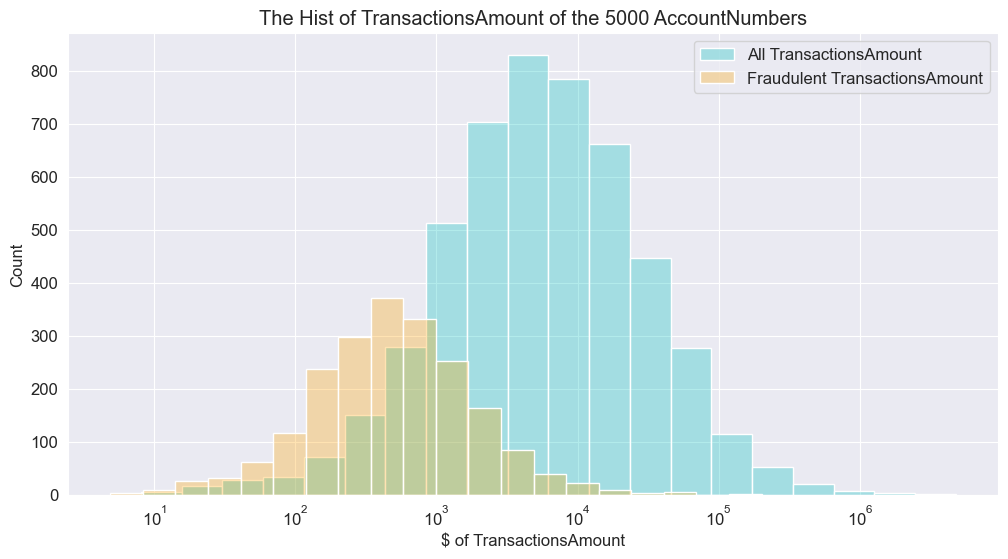

In [264]:
# superpose the above 2 hists on one axis
sns.histplot(b, bins=20, color='c', log_scale=True, label='All TransactionsAmount', alpha=0.3)
sns.histplot(a, bins=20, color='orange', log_scale=True, label='Fraudulent TransactionsAmount', alpha=0.3)
plt.title('The Hist of TransactionsAmount of the 5000 AccountNumbers')
plt.xlabel('$ of TransactionsAmount')
plt.legend()

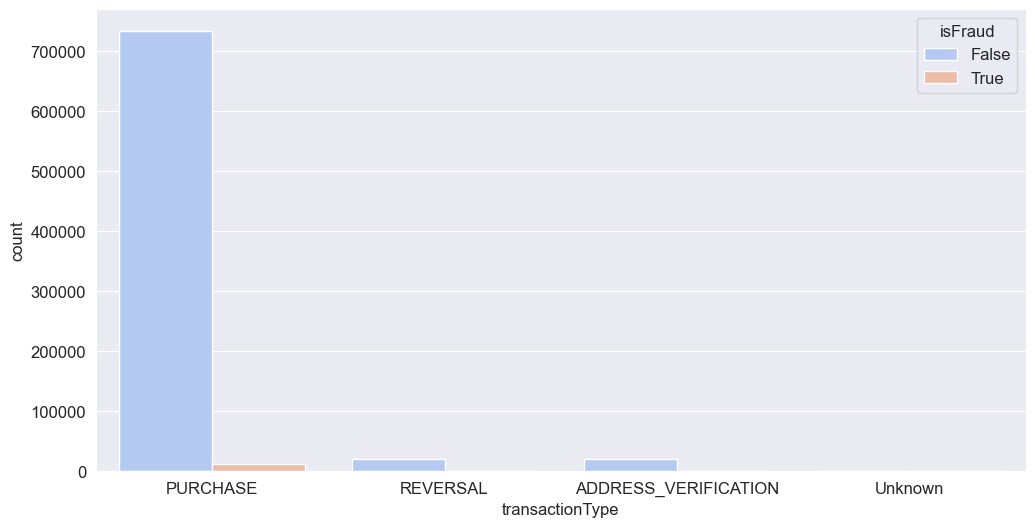

In [265]:
# Q: What are the typical transaction types for the fraudulent transactions?
# A: The fraudulent transactions are mostly 'PURCHASE' and 'ADDRESS_VERIFICATION'.
sns.countplot(x='transactionType', data=df, palette='coolwarm', hue=df['isFraud'], order=df['transactionType'].value_counts().index)
plt.show()

In [266]:
# Q: what is the ratio of the fraudulent transactions when the transaction type is 'PURCHASE'?
# A: 1.6% of the 'PURCHASE' transactions are fraudulent.
df[df['transactionType']=='PURCHASE']['isFraud'].value_counts()/df[df['transactionType']=='PURCHASE'].shape[0]

isFraud
False    0.983964
True     0.016036
Name: count, dtype: float64

In [267]:
# Q: what is the ratio of the fraudulent transactions when the transaction type is 'ADDRESS_VERIFICATION'?
# A: 0.5% of the 'ADDRESS_VERIFICATION' transactions are fraudulent.
df[df['transactionType']=='ADDRESS_VERIFICATION']['isFraud'].value_counts()/df[df['transactionType']=='ADDRESS_VERIFICATION'].shape[0]

isFraud
False    0.994249
True     0.005751
Name: count, dtype: float64

In [268]:
# Q: what is the ratio of the fraudulent transactions when the transaction type is 'REVERSAL'?
# A: 0.1% of the 'REVERSAL' transactions are fraudulent.
df[df['transactionType']=='REVERSAL']['isFraud'].value_counts()/df[df['transactionType']=='REVERSAL'].shape[0]

isFraud
False    0.983401
True     0.016599
Name: count, dtype: float64

In [269]:
# Q: what is the ratio of the fraudulent transactions when the transaction type is 'Unknown'?
# A: 2.0% of the 'Unknown' transactions are fraudulent.
df[df['transactionType']=='Unknown']['isFraud'].value_counts()/df[df['transactionType']=='Unknown'].shape[0]

isFraud
False    0.979943
True     0.020057
Name: count, dtype: float64

In [270]:
# List the top 10 merchants affected by the number of fraudulent transactions most
a = df[df['isFraud']==1]['merchantName'].value_counts().sort_values(ascending=False)
a.head(10)

merchantName
Lyft             760
ebay.com         639
Fresh Flowers    553
Uber             512
EZ Putt Putt     490
walmart.com      446
cheapfast.com    442
sears.com        422
oldnavy.com      401
staples.com      399
Name: count, dtype: int64

In [271]:
# List the top 10 merchants affected by the fraudulent transactionamounts most
a = df[df['isFraud']==1].groupby('merchantName')['transactionAmount'].sum().sort_values(ascending=False)
a.head(10)

merchantName
Lyft             178531.91
Fresh Flowers    138598.46
ebay.com         137875.43
Uber             122215.31
walmart.com      110100.36
cheapfast.com    105015.67
staples.com       99991.49
sears.com         99298.80
alibaba.com       98162.38
oldnavy.com       94500.42
Name: transactionAmount, dtype: float64

posEntryMode: It identifies the actual method used to enter the cardholder account number and card expiration date. This code specifies whether the entire magnetic stripe is included in an authorization if request. https://www.mreports.com/documentation/ac/nonmerchant/80451.htm
![](posEntryMode.jpg)]

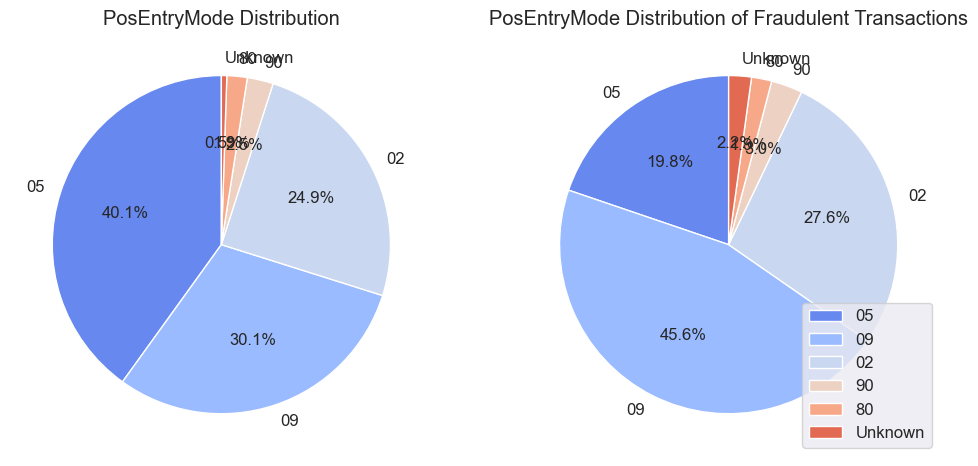

In [272]:
# PosEntryMode distribution by the y column in 2 pie charts
a = df[['posEntryMode', 'isFraud']].groupby('posEntryMode').agg(['count','sum'])
a.columns = ['% of all', '% of Fraudulent']
a = a.sort_values(by='% of all', ascending=False)
fig, ax = plt.subplots(1,2, figsize=(12,6))
ax[0].pie(a['% of all'], labels=a.index, autopct='%1.1f%%', startangle=90, colors=sns.color_palette('coolwarm', len(a)))
ax[0].set_title('PosEntryMode Distribution')
ax[1].pie(a['% of Fraudulent'], labels=a.index, autopct='%1.1f%%', startangle=90, colors=sns.color_palette('coolwarm', len(a)))
ax[1].set_title('PosEntryMode Distribution of Fraudulent Transactions')
plt.legend(loc=4)
plt.show()

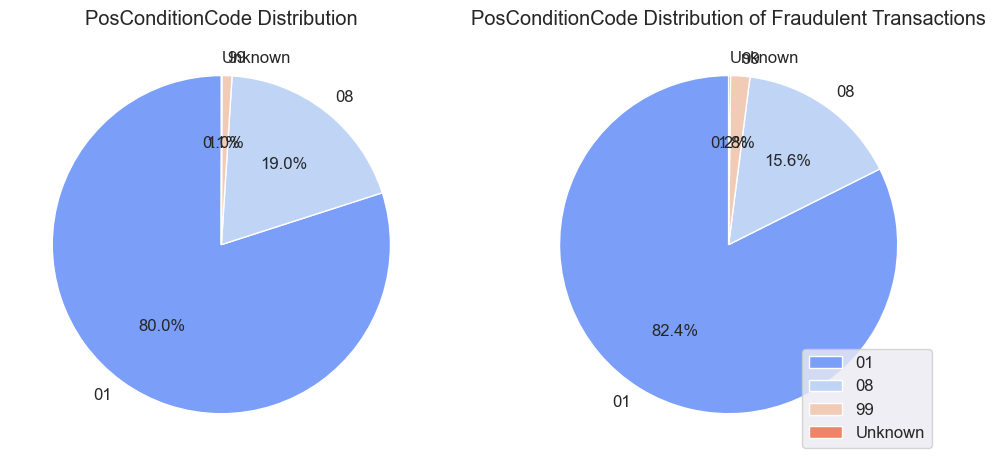

In [273]:
# PosConditionCode distribution by the y column in 2 pie charts
a = df[['posConditionCode', 'isFraud']].groupby('posConditionCode').agg(['count','sum'])
a.columns = ['% of all', '% of Fraudulent']
a = a.sort_values(by='% of all', ascending=False)
fig, ax = plt.subplots(1,2, figsize=(12,6))
ax[0].pie(a['% of all'], labels=a.index, autopct='%1.1f%%', startangle=90, colors=sns.color_palette('coolwarm', len(a)))
ax[0].set_title('PosConditionCode Distribution')
ax[1].pie(a['% of Fraudulent'], labels=a.index, autopct='%1.1f%%', startangle=90, colors=sns.color_palette('coolwarm', len(a)))
ax[1].set_title('PosConditionCode Distribution of Fraudulent Transactions')
plt.legend(loc=4)
plt.show()

Text(0, 0.5, 'Number of Transactions')

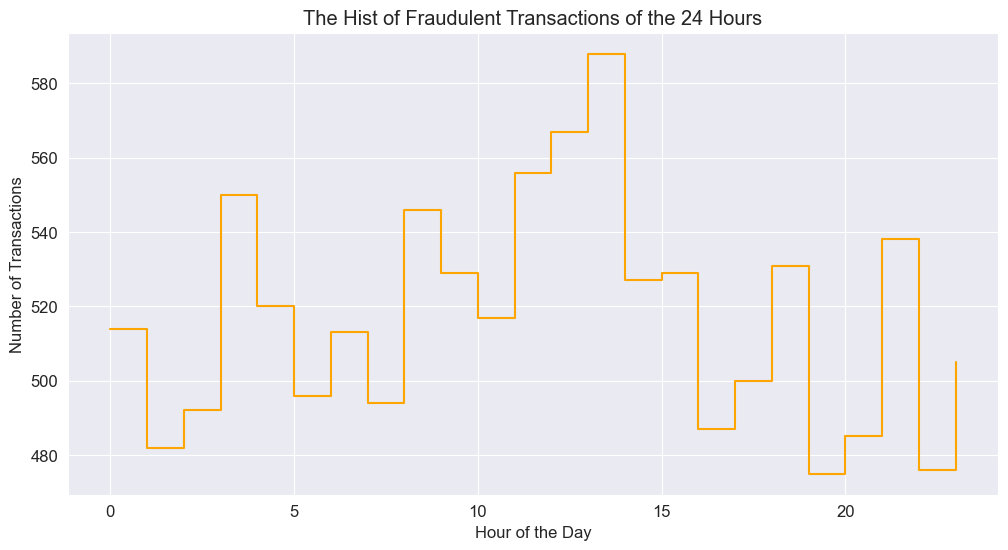

In [274]:
# At which hour of the day do the most fraudulent transactions occur?
# The most fraudulent transactions occur at 3 pm.
a = df[df['isFraud']==1]['x_hr'].value_counts().sort_values(ascending=False)
# stepplot 
sns.lineplot(x=a.index, y=a.values, drawstyle='steps-post', color='orange')
plt.title('The Hist of Fraudulent Transactions of the 24 Hours')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Transactions')

Text(0, 0.5, 'Number of Transactions')

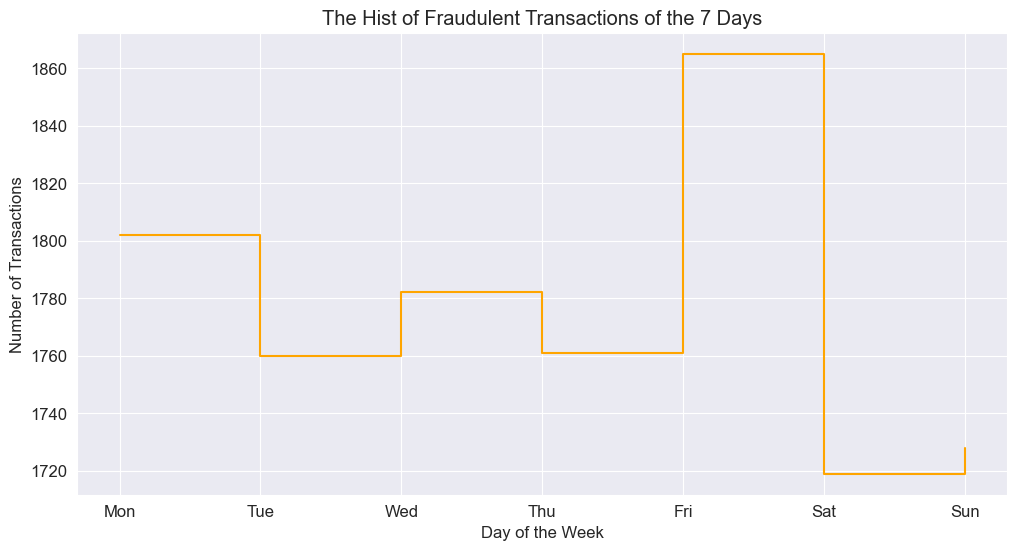

In [275]:
# At which day of the week do the most fraudulent transactions occur?
# The most fraudulent transactions occur on Friday.
a = df[df['isFraud']==1]['x_DOW'].value_counts().sort_values(ascending=False)
# stepplot
sns.lineplot(x=a.index, y=a.values, drawstyle='steps-post', color='orange')
plt.title('The Hist of Fraudulent Transactions of the 7 Days')
plt.xlabel('Day of the Week')
# change the x tick lables to the actual day names
plt.xticks(ticks=range(7), labels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.ylabel('Number of Transactions')

Text(0, 0.5, 'Number of Transactions')

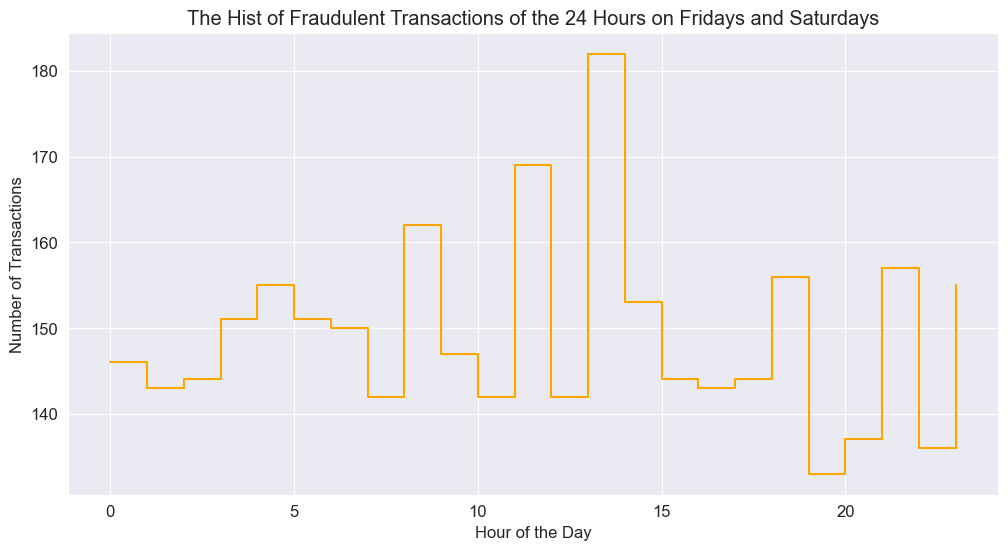

In [276]:
# On Fridays and Saturdays, what is the distribution of fraudulent transactions by the hour of the day?
# The fraudulent transactions are more evenly distributed on Fridays and Saturdays.
a = df[df['isFraud']==1]
a = a[(a['x_DOW']==4) | (a['x_DOW']==5)]
a = a['x_hr'].value_counts().sort_values(ascending=False)
# stepplot
sns.lineplot(x=a.index, y=a.values, drawstyle='steps-post', color='orange')
plt.title('The Hist of Fraudulent Transactions of the 24 Hours on Fridays and Saturdays')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Transactions')

In [ ]:
tbc

In [ ]:
# credit Limit could be ordinal, # 讲imputation的时候注意一下 在不同组的分布  
# 尝试倒推fraudler的时间策略，比如在周五下午3点的时候，fraudler更容易成功，然后我们可以在这个时间点加强监控。 # amount=0 有什么特殊含义吗？ 有可能是address verification，或者是退款，或者是免费的东西  
# 其实amount=0 fraud 的比例是最高的，这个是不是fraduler在测试卡号的时候用的？ 这个要用时间来看了。那就需要加入分钟数了。  
# Corr heatmap 可以加入binary columns  S
# 可以用chi2 test来检验两个categorical columns之间的关系，是不是也可以用来检验missing和non-missing 组的fraud or non-fraud 的比例？

In [ ]:
在Missing 时候看一下categorial的cardinality。cardinality很高的，其实没用，可以drop
这里除了时间，没有cardinality特别高的，其实最终不会直接train on
# 看一下transaction time的span，是不是有一些时间段fraud比例特别高
# 除了time dependent fraud #, 也有time dependent fraud rate
# model ensemble

In [ ]:
last 4 digits with only 3 numbers. Capital One does not issue credit cards in the American Express (Amex) network.

In [ ]:
no idea what echoBuffer is

In [ ]:
posonpremises is legacy pos with physical infrastructure, right?

In [ ]:
The term "expirationdatekeyinmatch" typically refers to a situation where a system or software prompts a user to input or match an expiration date for verification or authentication purposes. It could be part of a security protocol where a user is required to enter a specific expiration date associated with a card, document, or other credential to confirm its validity or access rights. This term is commonly used in contexts such as payment processing, access control systems, or any situation where validating the expiration of a document or credential is necessary.

posConditionCode: It is a code identifying transaction conditions at the point-of-sale. https://www.mreports.com/documentation/ac/nonmerchant/80449.htm

       